In [1]:
from LIMxCMBL.init import *
from LIMxCMBL.noise import *
from scipy.signal.windows import dpss
import sys
# Lambda_idx = int(sys.argv[1])
# log2 = int(sys.argv[2])

Lambda_idx = 13
log2 = 12

Lambda = Lambdas[Lambda_idx]
print(Lambda)


# CCAT-prime
zmin = 3.5
zmax = 8.1

Omega_field = 8 * (np.pi/180)**2 #rad^2
Pei = 2.3e4 #Mpc^3 kJy^2 /sr^2 
chimin = ccl.comoving_angular_distance(cosmo, 1/(1+zmin))
chimax = ccl.comoving_angular_distance(cosmo, 1/(1+zmax))

0.0014677992676220691


In [2]:
# get CMB lensing component
from LIMxCMBL.kernels import get_f_Kkappa
f_WkD = get_f_Kkappa()

from LIMxCMBL.cross_spectrum import *
ClKK = d_chib_integral(f_WkD, f_WkD) #[Mpc]^2


# beam=1.4, noise=7
from scipy.interpolate import interp1d
N0_ells = np.logspace(1, np.log10(5000), 500)
with open('LIMxCMBL/N0.npy', 'rb') as f:
    N0 = np.load(f)
    
f_N0 = interp1d(x = N0_ells, y = N0)


# if no high pass IKappa
from  LIMxCMBL.kernels import *
f_KLIM   = get_f_KI()
f_Kkappa = get_f_Kkappa()

f_KLIM_windowed = apply_window(f_K = f_KLIM,
                               chimin = chimin,
                               chimax = chimax)

Ik_fname = '/scratch/users/delon/LIMxCMBL/IHiKappa/Ik_zmin_%.5f_zmax_%.5f_chi_sample_%d.npy'%(zmin, zmax, log2)
I_kappa = np.load(Ik_fname)

external_chis     =  np.linspace(chimin*(1+1e-8), chimax*(1 - 1e-8), 2**log2)

mpm_external_chis = mpm.linspace(chimin*(1+1e-8), chimax*(1 - 1e-8), 2**log2)
mpm_dchi = mpm_external_chis[1] - mpm_external_chis[0]

mpm_oup_fname = '/scratch/users/delon/LIMxCMBL/eHIeHI/mpmath_zmin_%.5f_zmax_%.5f_Lambda_%.5e_log2_%d.npy'%(zmin, zmax, Lambda, log2)
print(mpm_oup_fname)
with open(mpm_oup_fname, 'rb') as f:
    results = pickle.load(f)

shape = (2**log2, 2**log2)
mpm_eIeI = np.zeros(shape, dtype=np.complex128)
mpm_eLOeLO = np.zeros(shape, dtype=np.complex128)
mpm_cross = np.zeros(shape, dtype=np.complex128)

for i, j, _eIeI, _cross, _eLOeLO in tqdm(results):
    mpm_eIeI[i,j] = _eIeI
    mpm_eLOeLO[i,j] = mpm_eLOeLO[j,i] = _eLOeLO
    mpm_cross[i,j] = mpm_cross[j,i] = _cross

mpm_eHIeHI = mpm_eIeI + mpm_eLOeLO - mpm_cross
mpm_eHIeHI = np.real(mpm_eHIeHI)
mpm_eIeI = np.real(mpm_eIeI)

ILo_kappa_fname = '/scratch/users/delon/LIMxCMBL/IHiKappa/ILok_zmin_%.5f_zmax_%.5f_Lambda_%.5f_chi_sample_%d.npy'%(zmin, zmax, Lambda, log2)
ILo_kappa = np.load(ILo_kappa_fname)
IHi_kappa = (I_kappa - ILo_kappa).astype(np.float64)

/scratch/users/delon/LIMxCMBL/eHIeHI/mpmath_zmin_3.50000_zmax_8.10000_Lambda_1.46780e-03_log2_12.npy


100%|██████████| 8390656/8390656 [01:18<00:00, 106296.49it/s]


In [3]:
2**12

4096

Text(0, 0.5, '$\\log_{10}(\\ell)$')

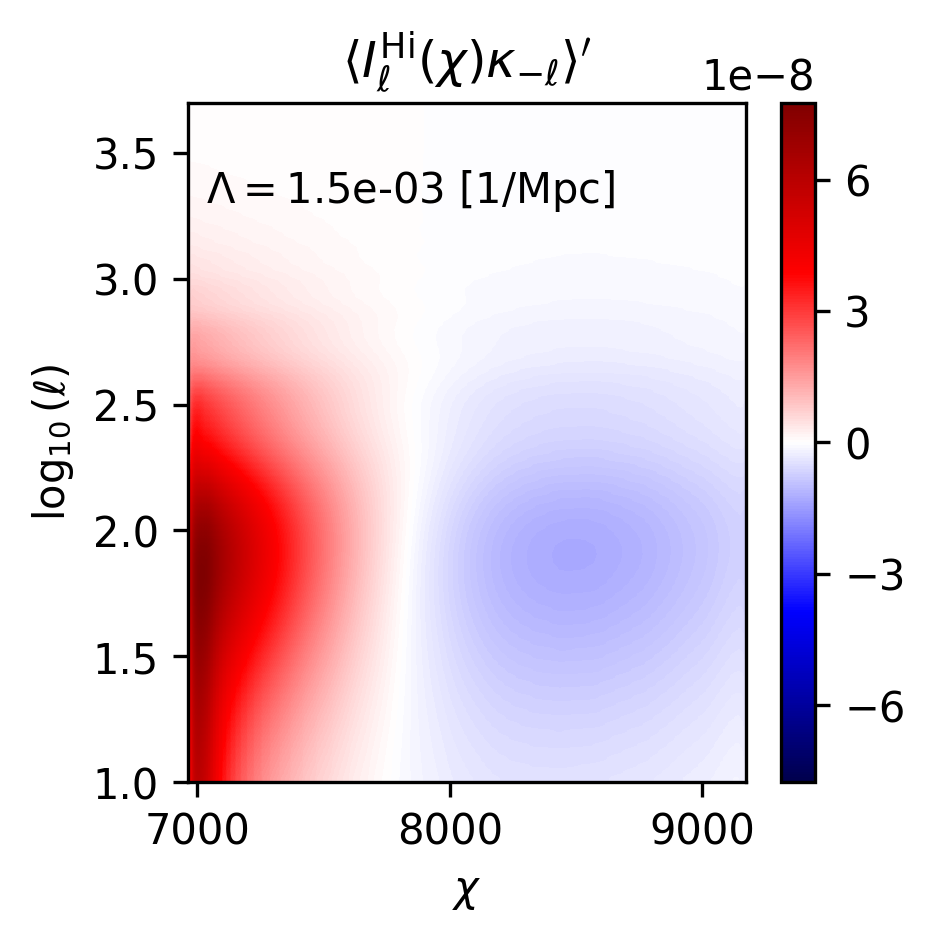

In [4]:
vminmax = np.max(np.abs(IHi_kappa))
plt.figure(figsize=(3,3), dpi=300, facecolor='w',)
log_ymin = np.log10(ells[0])
log_ymax = np.log10(ells[-1])
# plot data
im = plt.imshow(IHi_kappa, 
           origin='lower',
          cmap = 'seismic',
          vmin = -vminmax,
          vmax =  vminmax,
           aspect = 'auto',
          extent=[chimin, chimax, log_ymin, log_ymax])

cbar = plt.colorbar(im, ticks=[-6e-8, -3e-8,0,3e-8,6e-8])


# set bounds
plt.title(r"$\langle I_{ \ell}^{\sf Hi}(\chi) \kappa_{- \ell}\rangle'$")
plt.text(chimin*(1+0.01), 3.3, '$\Lambda =$%.1e [1/Mpc]'%(Lambda))
plt.xlabel(r'$\chi$')
plt.ylabel(r"$\log_{10}(\ell)$")

In [5]:
nbins = 100
chi_bin_edges = np.linspace(chimin*(1+1e-8), chimax*(1 - 1e-8), nbins + 1)
chi_bin_centers = (chi_bin_edges[1:] + chi_bin_edges[:-1])/2
IHi_kappa_binned = np.zeros((len(ells),nbins), dtype=np.float64)
eHIeHI_binned = np.zeros((nbins,nbins), dtype=np.float64)

In [6]:
for i, (left, right) in enumerate(zip(chi_bin_edges, chi_bin_edges[1:])):
    idxs = np.where((external_chis > left) & (external_chis <= right))[0]
    IHi_kappa_binned[:, i] = np.sum(IHi_kappa[:, idxs], axis=-1) / len(idxs)

Text(0, 0.5, '$\\log_{10}(\\ell)$')

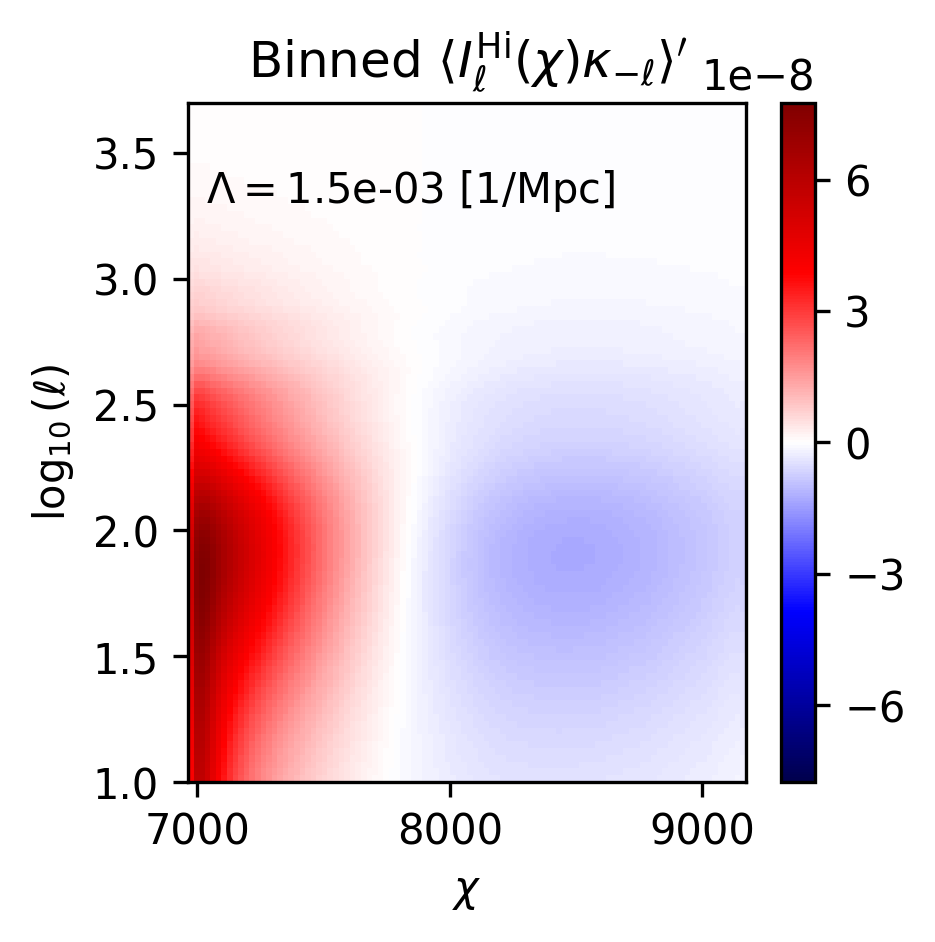

In [7]:
plt.figure(figsize=(3,3), dpi=300, facecolor='w',)
log_ymin = np.log10(ells[0])
log_ymax = np.log10(ells[-1])
# plot data
im = plt.imshow(IHi_kappa_binned, 
           origin='lower',
          cmap = 'seismic',
          vmin = -vminmax,
          vmax =  vminmax,
           aspect = 'auto',
          extent=[chimin, chimax, log_ymin, log_ymax])

cbar = plt.colorbar(im, ticks=[-6e-8, -3e-8,0,3e-8,6e-8])


# set bounds
plt.title(r"Binned $\langle I_{ \ell}^{\sf Hi}(\chi) \kappa_{- \ell}\rangle'$")
plt.text(chimin*(1+0.01), 3.3, '$\Lambda =$%.1e [1/Mpc]'%(Lambda))
plt.xlabel(r'$\chi$')
plt.ylabel(r"$\log_{10}(\ell)$")

In [8]:
for i, (l1, r1) in enumerate(zip(chi_bin_edges, chi_bin_edges[1:])):
    for j, (l2, r2) in enumerate(zip(chi_bin_edges, chi_bin_edges[1:])):
        idx1 = np.where((external_chis > l1) & (external_chis <= r1))[0]
        idx2 = np.where((external_chis > l2) & (external_chis <= r2))[0]
        eHIeHI_binned[i,j] = np.sum(mpm_eHIeHI[idx1[0]:idx1[-1]+1,idx2[0]:idx2[-1]+1]) / len(idx1) / len(idx2)

Text(0, 0.5, "$\\chi'$")

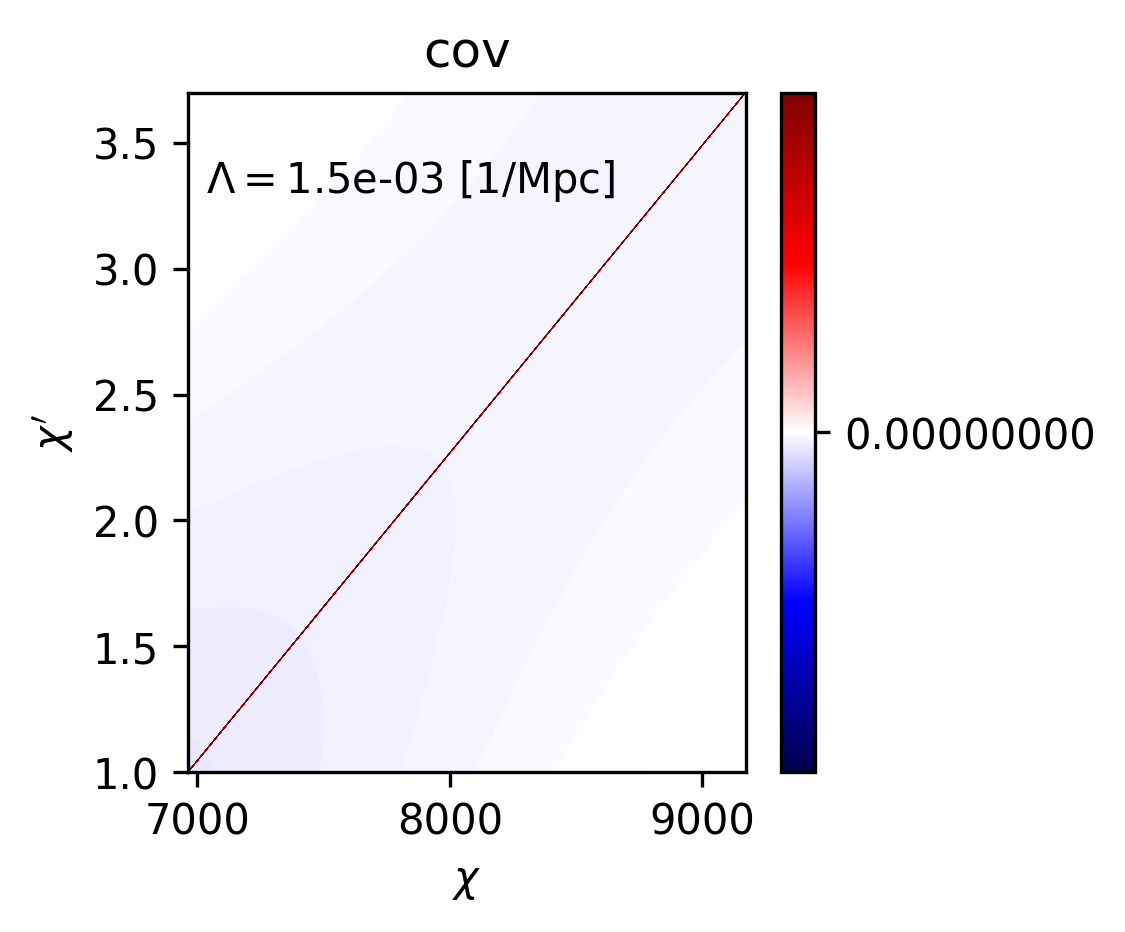

In [9]:
vminmax = np.max(np.abs(mpm_eHIeHI))
plt.figure(figsize=(3,3), dpi=300, facecolor='w',)
# plot data
im = plt.imshow(mpm_eHIeHI, 
           origin='lower',
          cmap = 'seismic',
          vmin = -vminmax/100,
          vmax =  vminmax/100,
           aspect = 'auto',
          extent=[chimin, chimax, log_ymin, log_ymax])

cbar = plt.colorbar(im, ticks=[-6e-8, -3e-8,0,3e-8,6e-8])


# set bounds
plt.title(r"cov")
plt.text(chimin*(1+0.01), 3.3, '$\Lambda =$%.1e [1/Mpc]'%(Lambda))
plt.xlabel(r'$\chi$')
plt.ylabel(r"$\chi'$")


Text(0, 0.5, "$\\chi'$")

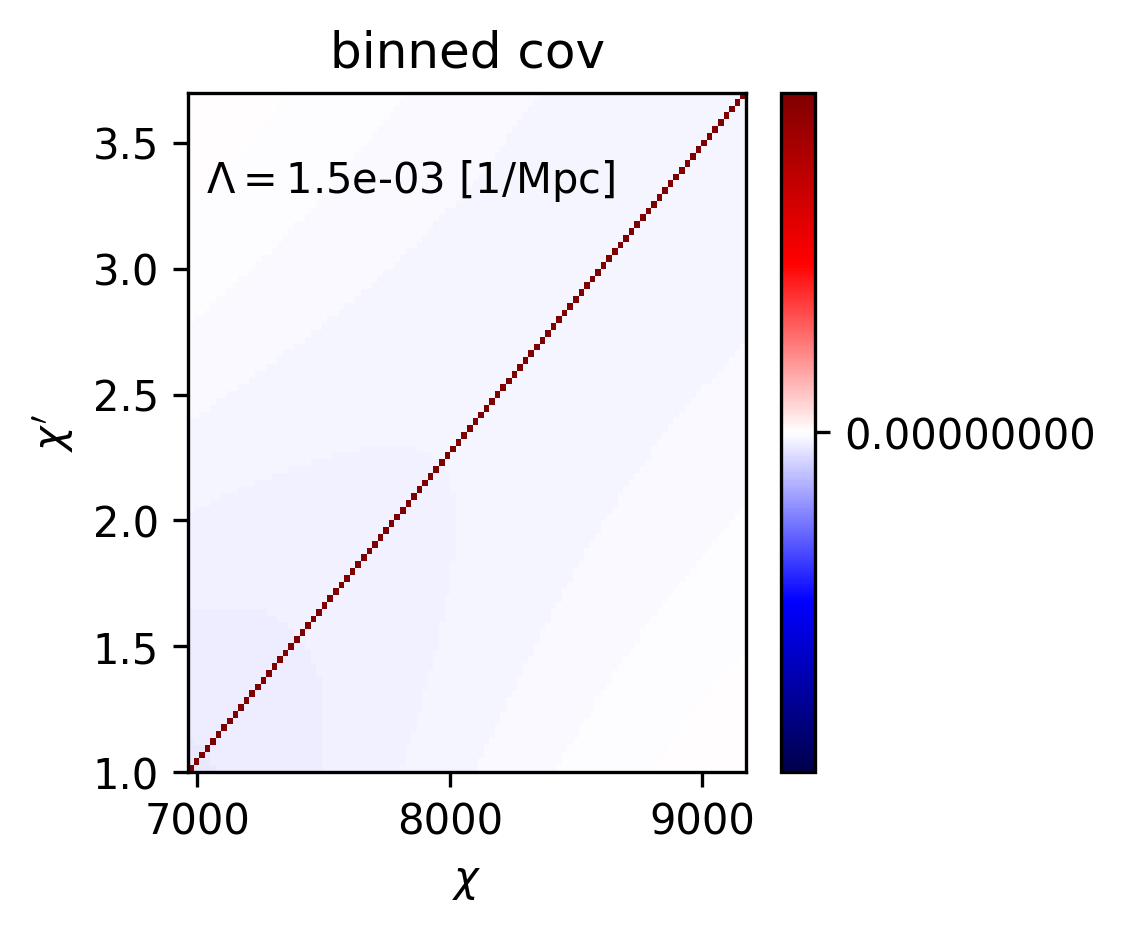

In [10]:
plt.figure(figsize=(3,3), dpi=300, facecolor='w',)
# plot data
im = plt.imshow(eHIeHI_binned, 
           origin='lower',
          cmap = 'seismic',
          vmin = -vminmax/100,
          vmax =  vminmax/100,
           aspect = 'auto',
          extent=[chimin, chimax, log_ymin, log_ymax])

cbar = plt.colorbar(im, ticks=[-6e-8, -3e-8,0,3e-8,6e-8])


# set bounds
plt.title(r"binned cov")
plt.text(chimin*(1+0.01), 3.3, '$\Lambda =$%.1e [1/Mpc]'%(Lambda))
plt.xlabel(r'$\chi$')
plt.ylabel(r"$\chi'$")


In [11]:
L = np.linalg.cholesky(eHIeHI_binned)
y = np.linalg.solve(L, IHi_kappa_binned.T)
x = np.linalg.solve(L.T, y)
binned_snr_per_mode = np.einsum('ij,ji->i', IHi_kappa_binned, x) / (ClKK + f_N0(ells))

In [12]:
L = np.linalg.cholesky(mpm_eHIeHI)
y = np.linalg.solve(L, IHi_kappa.T)
x = np.linalg.solve(L.T, y)
snr_per_mode = np.einsum('ij,ji->i', IHi_kappa, x) / (ClKK + f_N0(ells))

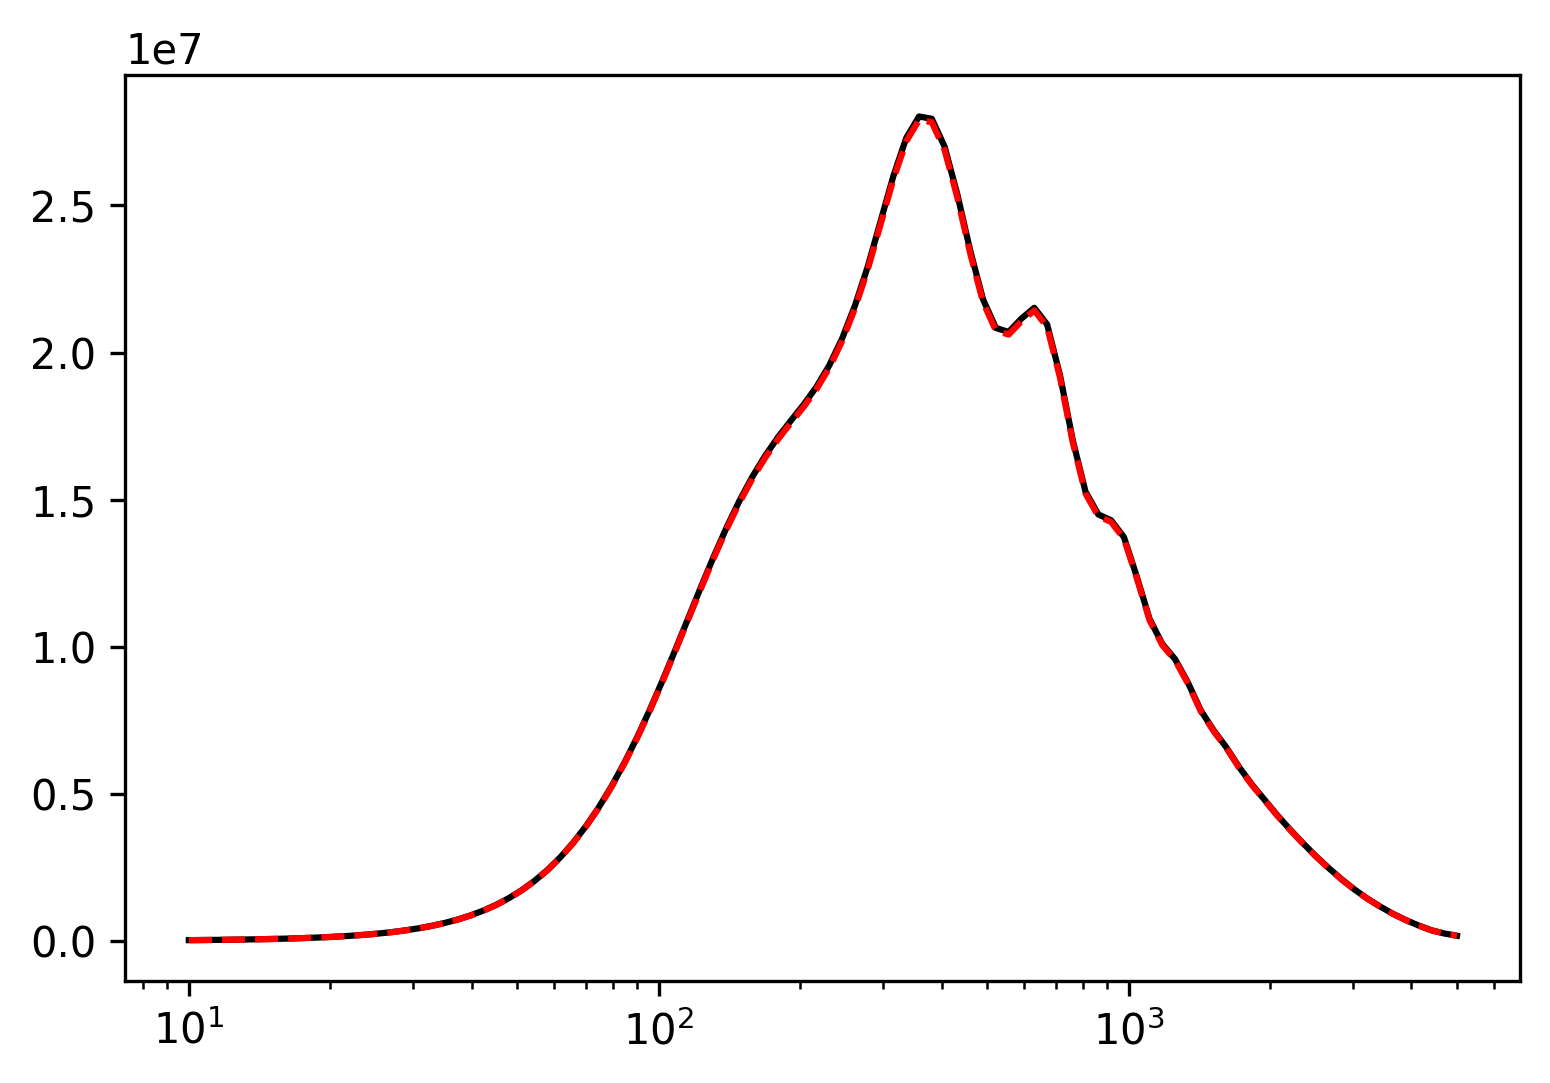

In [13]:
plt.figure(dpi = 300)
plt.plot(ells, ells**2 * snr_per_mode, c='k')

plt.plot(ells, ells**2 * binned_snr_per_mode, 'r--')
plt.xscale('log')